In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import Ko

In [2]:
raw_per = pd.read_csv('Data/KOSPI_PCR_MONTHLY.csv', encoding = 'cp949', header = 7)
raw_rt = pd.read_csv('Data/KOSPI_SILH_SUIK_RT_WITH_DIVIDEND_MONTHLY.csv', encoding = 'cp949', header = 7)

In [8]:
def Preprocessing(raw):
    
    CD_list = list(raw.iloc[0,1:])
    name_list = list(raw.iloc[1,1:])
    month_list = list(raw.iloc[6:,0].apply(lambda x: x.replace('-','')))
    
    
    df = pd.DataFrame(raw.iloc[6:,1:].values,
                     index = month_list,
                     columns = name_list).T
    
    
    def __remove_comma(column):
        column = [float(x.replace(',','')) if type(x) == str else float(x) for x in column]
        return column
        
    df = df.apply(lambda x: __remove_comma(x))
    
    return df

In [4]:
per_df = Preprocessing(raw_per)

In [5]:
def rt_transform(column):
    return column.apply(lambda x: x/100 +1)

In [6]:
rt_df = Preprocessing(raw_rt).apply(lambda x: rt_transform(x))

In [7]:
def portfolio_selection(df):
    
    # 높을수록 1그룹
    # 낮을수록 4그룹
    
    data = df.copy()
    
    month_list = df.columns
    name_list = df.index

    # t월의 지표 횡단면을 분석하여, t+1월의 1일에 투자하는 것을 목표로 한다.
    # 따라서 t월 30일을 기준으로 포트폴리오를 그룹핑하고, t+1월 1일 부터 투자한다.
    # t+1월에 새로 상장된 주식의 경우 t월 성과가 없기 때문에 t+1월에는 투자되지 않는다 (0으로 처리)
    # t+1월에 사라진 주식은 t월 성적이 존재하지만 투자가 불가능하므로, t+1월에 제거하여 0으로 처리한다
    
    for cnt, month in enumerate(month_list):
        
        temp_t = df[month].dropna()
        
        # 첫월은 제외한다
        if cnt == 0:
            data[month] = 0
            t_index_list = temp_t.index
            
        # 마지막 월을 제외하고 결과를 확인한다
        if not cnt == len(month_list) - 1:
            
            temp_t_plus_1 = df[month_list[cnt+1]].dropna()
            
            
            t_index_list = temp_t.index
            t_plus_1_index_list = temp_t_plus_1.index
            
            
            
            # t월에 존재하지 않았던 펀드들은 t+1월에 0그룹으로 따로 분류한다 (t월 : x, t+1월 : 0)
            t_no_existence_list = [x for x in name_list if not x in t_index_list]
            
            # t월에 존재하였지만 t+1월에 사라진 종목들은 t+1월에 0그룹으로 분류한다 (t월 : 존재, t+1월: 사라짐)
            t_1_disappear_list = [x for x in t_index_list if not x in t_plus_1_index_list]
            
            
            # 그룹핑을 위한 분위값 계산
            Q_3 = np.percentile(temp_t.values, 25)
            Q_2 = np.percentile(temp_t.values, 50)
            Q_1 = np.percentile(temp_t.values, 75)

            # 각각의 그룹에 포함될 주식명 (index)를 기록한다
            df_1Q = temp_t > Q_1
            df_1Q_index = df_1Q[df_1Q == True].index

            df_2Q = temp_t[temp_t > Q_2] < Q_1
            df_2Q_index = df_2Q[df_2Q == True].index

            df_3Q = temp_t[temp_t > Q_3] < Q_2
            df_3Q_index = df_3Q[df_3Q == True].index

            df_4Q = temp_t < Q_3
            df_4Q_index = df_4Q[df_4Q == True].index



            
            # t월에 존재하지 않았던 종목은 t+1월에 0으로 처리한다
            data.loc[t_no_existence_list, month_list[cnt+1]] = 0
            
            # t월에 존재했지만 t+1월에 사라진 종목들은 역시 0로 따로 처리한다.
            data.loc[t_1_disappear_list, month_list[cnt+1]] = 9

            
            # t월 성과룰 바탕으로 t+1월 포트폴리오 그룹핑을 수행한다
            data.loc[df_1Q_index, month_list[cnt+1]] = 1
            data.loc[df_2Q_index, month_list[cnt+1]] = 2
            data.loc[df_3Q_index, month_list[cnt+1]] = 3
            data.loc[df_4Q_index, month_list[cnt+1]] = 4

    
    
    return data

In [8]:
data = portfolio_selection(per_df)

In [9]:
data.shape

(768, 345)

In [10]:
data.drop([x for x in data.index if not x in rt_df.index], axis=0, inplace = True)

In [11]:
data.shape

(758, 345)

In [12]:
rt_df.shape

(758, 345)

In [13]:
data.to_csv('PCR.csv')

# 포트폴리오 성과분석

In [14]:
def performance_analysis(data, rt_df):

    month_list = data.columns

    group_rt_dict = {'GROUP_1' : [],
                     'GROUP_2' : [],
                     'GROUP_3' :[],
                     'GROUP_4' :[],
                    }

    for cnt,month in enumerate(month_list):

        # 최초월 1일에는 1원씩 투자
        if cnt == 0 :
            for i in range(1,5):
                group_rt_dict['GROUP_%s'%i].append(1)

        # 둘째 달부터는 1일에 전달 기록에 근거한 투자를 한다
        else:
            temp = data[month]

            for i in range(1,5): # i는 1,2,3,4
                group_index = temp[temp == i].index
                
                #print(month, i,  len(group_index))

                group_mean_rt = np.mean(rt_df.loc[group_index, month].dropna().values)
                group_rt_dict['GROUP_%s'%i].append(group_mean_rt)
    
    return pd.DataFrame(group_rt_dict)
    

In [15]:
result = performance_analysis(data, rt_df)
result.index = pd.to_datetime(data.columns, format = '%Y%m%d')

In [16]:
result.min()

GROUP_1    0.699357
GROUP_2    0.717768
GROUP_3    0.719672
GROUP_4    0.706548
dtype: float64

In [25]:
result.max()

GROUP_1    1.383830
GROUP_2    1.525179
GROUP_3    1.547574
GROUP_4    1.590586
dtype: float64

# 1990년대

Text(0.5,1,'Performance result by PCR Group')

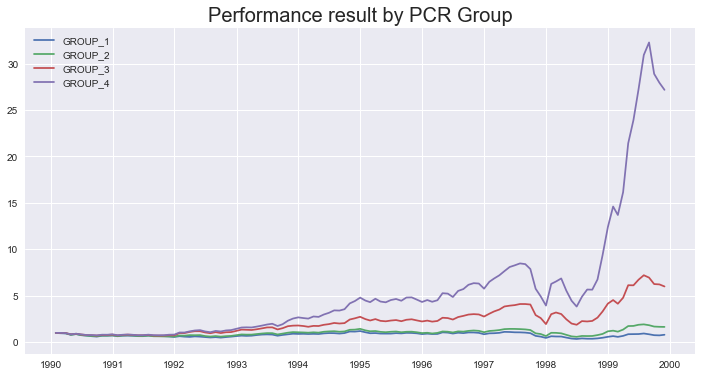

In [26]:
plt.figure(figsize = (12,6))

for column in result.columns:
    plt.plot(result[column].iloc[:119].cumprod(), label = column)

plt.legend(loc = 'best')
plt.title('Performance result by PCR Group', fontsize = 20)

# 2000 년대

Text(0.5,1,'Performance result by PCR Group')

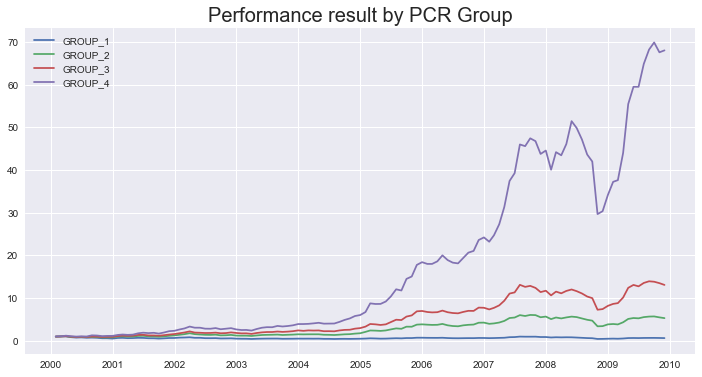

In [27]:
plt.figure(figsize = (12,6))

for column in result.columns:
    plt.plot(result[column].iloc[120:239].cumprod(), label = column)

plt.legend(loc = 'best')
plt.title('Performance result by PCR Group', fontsize = 20)

# 2010년대

Text(0.5,1,'Performance result by PCR Group')

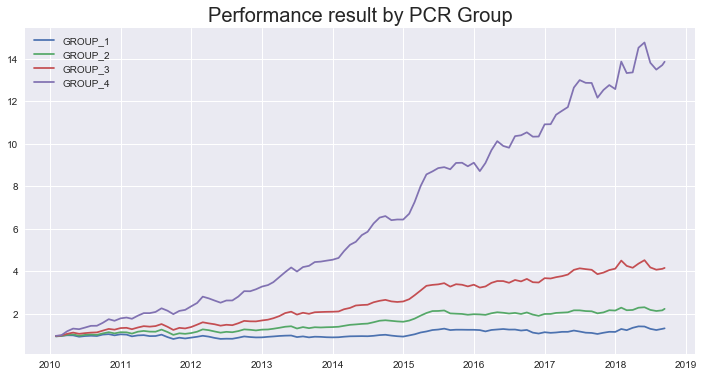

In [28]:
plt.figure(figsize = (12,6))

for column in result.columns:
    plt.plot(result[column].iloc[240:].cumprod(), label = column)

plt.legend(loc = 'best')
plt.title('Performance result by PCR Group', fontsize = 20)

Text(0.5,1,'Performance result by PCR Group')

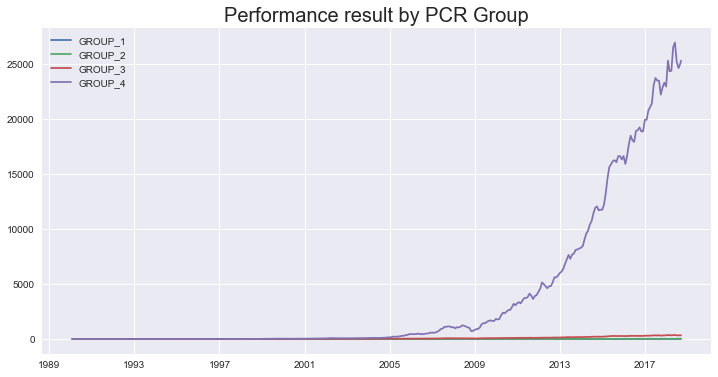

In [29]:
plt.figure(figsize = (12,6))

for column in result.columns[:4]:
    plt.plot(result[column].cumprod(), label = column)

plt.legend(loc = 'best')
plt.title('Performance result by PCR Group', fontsize = 20)

Text(0.5,1,'Performance result by PCR Group')

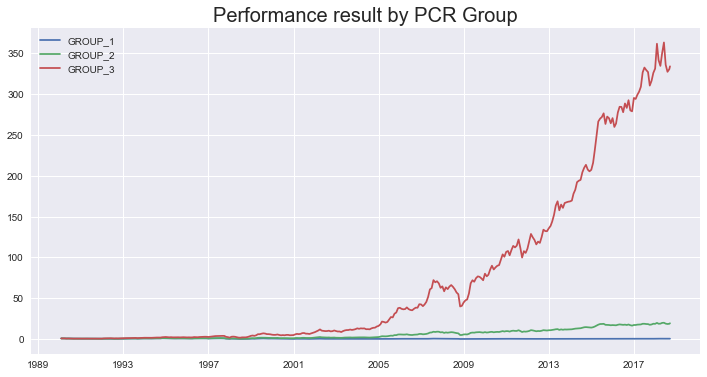

In [30]:
plt.figure(figsize = (12,6))

for column in result.columns[:3]:
    plt.plot(result[column].cumprod(), label = column)

plt.legend(loc = 'best')
plt.title('Performance result by PCR Group', fontsize = 20)

Text(0.5,1,'Monthly return distribution by PCR Group')

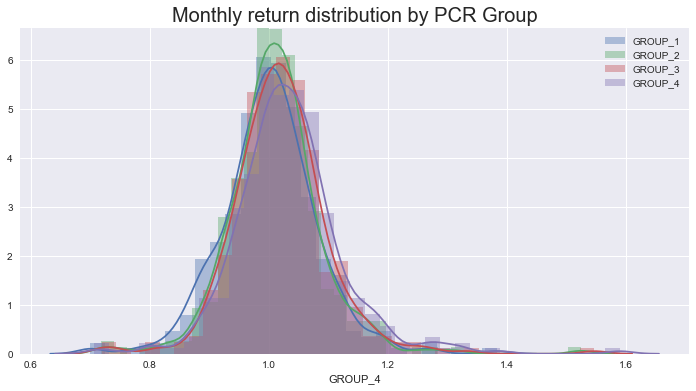

In [31]:
plt.figure(figsize = (12,6))

for column in result.columns:
    sns.distplot(result[column], label = column)

plt.legend(loc = 'best')
plt.title('Monthly return distribution by PCR Group', fontsize = 20)

In [33]:
result.describe().apply(lambda x: round(x,3))

,GROUP_1,GROUP_2,GROUP_3,GROUP_4
count,345.000,345.000,345.000,345.000
mean,1.002,1.012,1.020,1.034
std,0.081,0.080,0.082,0.091
min,0.699,0.718,0.720,0.707
25%,0.957,0.972,0.974,0.984
50%,1.001,1.011,1.017,1.028
75%,1.047,1.049,1.060,1.073
max,1.384,1.525,1.548,1.591
